# Text Classification for Movie Reviews

## Goal

With this project, we aimed to use the machine learning skills in this class and apply it to a popular field in machine learning: text classification. We found a great dataset that put together 50,000 movie reviews for binary classification based on whether the movie review was positive or negative. This is useful for websites that serve as aggregates for movie reviews, such as Rotten tomatoes, as users can submit their reviews. 

The notebook is self contained and shares all the results for understanding, but should one want to run the code for themselves, here is the github link where our data lives.

https://github.com/Deionus/345-final

## Step 0: The Data and Procedure

The dataset comes from an article titled *Learning Word Vectors for Sentiment Analysis* written by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. It is very robust which will make it incredibly useful as large data sets help the accuracy of our classifier. It includes the text files of the 50,000 reviews along with some other processed data.

Furthermore, Miguel Fernández Zafra wrote an article titled *Text Classification in Python* that was helpful in explaining what natural language processing entailed and how machine learning fits in. The implementation and procedure was made on our own, but it gave us some useful ideas to consider for natural language processing as a whole.

Link to article: https://towardsdatascience.com/text-classification-in-python-dd95d264c802

## Step 1: Feature Exploration

The dataset divided the reviews into 25,000 positive reviews and 25,000 negative reviews split evenly into training and test sets. Furthermore, the creators of the dataset turned each review into a tokenized bag of words that matches with a vocab set. The vocab set list has every words that comes up in the review set and maps it to a number. However, there are still a few things we needed to do to get the data ready for classification.

## Step 2: Text Clean-Up and Transformation

While the bag of words is a great start, the word count doesn't give the whole story. We want to better represent the words by representing not only the word count in the review but how relative it is in document frequency (A word that appears in every document is not as useful as a word that only appears in positive movies for example. We will achieve this by using a tf-idf (term frequency to inverse document frequency) score which we will then vectorize to use for classification. While scikit-learn has a tdf function, it doesn't work with the bag of words given in the data, hence why we wrote our own implementation.

In [1]:
import math
import numpy as np

# Finding the frequency of each term

vocab = open("aclImdb/imdb.vocab", errors='ignore').read().splitlines()
trainReviews = open("aclImdb/train/labeledBow.feat").read().splitlines()
testReviews = open("aclImdb/test/labeledBow.feat").read().splitlines()
docFreqTrain = [0] * len(vocab)

for line in trainReviews:
    bag = line.split()
    bag.pop(0)
    for word in bag:
        pair = word.split(":")
        docFreqTrain[int(pair[0])] += 1 

# Calculating tf-idf score for standardizing

def TF_score(pair):
    left = int(pair[0])
    right = int(float(pair[1]))
    return right * math.log(25000/int(docFreqTrain[left]))

def getFile(reviews, score):
    updatedReviews = ""
    for line in reviews:
        bag = line.split()
        updateLine = "0 " if (int(bag.pop(0)) <= 4) else "1 "
        for word in bag:
            pair = word.split(":")
            updateLine += pair[0]
            updateLine += ":"
            updateLine += str(score(pair))
            updateLine += " "
        updateLine += "\n"
        updatedReviews += updateLine
    return updatedReviews

updatedReviewsTrain = getFile(trainReviews, TF_score)
updatedReviewsTest = getFile(testReviews, TF_score)

Next we will vectorize and turn the data into an array. We will treat each word in the vocab as a feature

In [2]:
TrainData = updatedReviewsTrain.splitlines()
TestData = updatedReviewsTest.splitlines()

TrainFeatures = np.zeros((len(TrainData), len(vocab)))
TrainLabels = np.zeros(len(TrainData))
TestFeatures = np.zeros((len(TestData), len(vocab)))
TestLabels = np.zeros(len(TestData))

for i in range(0, len(TrainData)):
    bag = TrainData[i].split()
    TrainLabels[i] = int(bag.pop(0))
    for word in bag:
        pair = word.split(":")
        TrainFeatures[i][int(pair[0])] = float(pair[1])

for i in range(0, len(TestData)):
    bag = TestData[i].split()
    TestLabels[i] = int(bag.pop(0))
    for word in bag:
        pair = word.split(":")
        TestFeatures[i][int(pair[0])] = float(pair[1])
        
print(TrainFeatures.shape, TrainLabels.shape)
print(TestFeatures.shape, TestLabels.shape)

(25000, 89527) (25000,)
(25000, 89527) (25000,)


Finally, just to see how the data perform without any optimization, we'll run it through a basic svm classifier and see how the accuracy is

/home/josh/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy of Train Set:  1.0 

Accuracy of Test Set:  0.84776


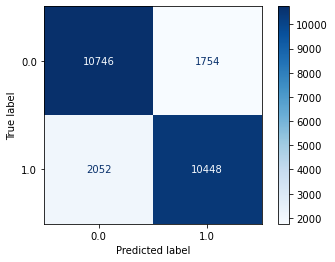

In [3]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix

svc = LinearSVC()
svc.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", svc.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", svc.score(TestFeatures, TestLabels))

plot_confusion_matrix(svc, TestFeatures, TestLabels, cmap=plt.cm.Blues, values_format='d')

The classifier has decent accuracy on the test, but as we can see when compared to the acurracy of the Train Set, we may have some overfitting that is not well generalized for test data. We also need to do a more in depth process for classification to figure out which classifier is the best overall. This will be covered in the next section

## Step 3: Further Refinement

Is the Linear SVM classifier going to be the best classifier to use for this data? To figure this out, let's test three more classifiers for binary classification problems. First, the Multinomial Naive Bayes Classifier, then a standard Perceptron, and finally a Neural Network Multi-Layer Perceptron Classifier. Once we compare these classifiers at their default Scikit Learn settings, we'll take the most promising one and tune it's hyperparameters.

The Naive Bayes classifier works by assuming independence among the features, and using Bayes' theorem in the decision rule. This classifier is best for text classification when each feature is an integer, and in practice will also work using TF-IDF vectors. Since we're using TF-IDF scores for our features, we expect this classifier to be less accurate than the LinearSVC classifier.

In [4]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", nb.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", nb.score(TestFeatures, TestLabels))

Accuracy of Train Set:  0.95504 

Accuracy of Test Set:  0.76976


As predicted, the MultinomialNB classifier is significantly less accurate than the LinearSVC classifier. It does not appear to be overfitting, but the test accuracy is not nearly as good as the test accuracy of the LinearSVC classifier.

Now, we'll fit the data to a perceptron and see how the score weighs in. As we learned in class, the perceptron classifier is a binary classifier which makes a decision based on a vector of numbers. This is perfect for our classification, as we are only predicting whether a movie got a negative or positive review. If the test accuracy of the perceptron is 1, that means the training data is linearly separable.

In [5]:
from sklearn.linear_model import Perceptron

percep = Perceptron()
percep.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", percep.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", percep.score(TestFeatures, TestLabels))

Accuracy of Train Set:  0.99952 

Accuracy of Test Set:  0.8438


On the initial test, Perceptron looks very promising! The accuracy of the Train set is very close to 1.0, meaning that the data is almost linearly separable. Since the accuracy on the training set is so close to 1.0, it's safe to assume that the LinearSVC classifier is not overfitting!

Lets take it a step further and search for better hyperparameters. For this, we'll use Grid Seach Cross Validation with a parameter grid to test different hyperparameters. Ideally, we'd be able to do this with the entire dataset, but because of it's massive size we need to shrink it to only 5,000 training samples instead of 25,000. 2,500 will be positive reviews, and 2,500 will be negative reviews. Then, we'll use this reduced set in the Grid Search CV. 

In [6]:
#Reduce training set to only 5000 data points to save RAM

RTrainFeatures = TrainFeatures[10000:15000, :]
RTestFeatures = TestFeatures[10000:15000, :]
RTrainLabels = TrainLabels[10000:15000]
RTestLabels = TestLabels[10000:15000]

print(RTrainFeatures.shape, RTrainLabels.shape)
print(RTestFeatures.shape, RTestLabels.shape)

(5000, 89527) (5000,)
(5000, 89527) (5000,)


In [7]:
#Grid Search CV with Perceptron
from sklearn.model_selection import GridSearchCV

#Focusing on the Tolerance and Max Iterations hyperparameters
param_grid = {'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
              'max_iter': [1000, 5000, 10000]}

perceptron_tuning = GridSearchCV(Perceptron(), param_grid)

perceptron_tuning.fit(RTrainFeatures, RTrainLabels)

print(perceptron_tuning.best_params_)

{'max_iter': 1000, 'tol': 0.1}


Now we'll try the recommended parameters on the full dataset and see if there is an improvement

In [8]:
percep = Perceptron(tol=1e-1, max_iter=1000)
percep.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", percep.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", percep.score(TestFeatures, TestLabels))

Accuracy of Train Set:  0.99972 

Accuracy of Test Set:  0.8438


As can be seen, the new hyperparameters marginally increased our accuracy on the traning set, but had no affect on the test set. And still, the LinearSVC classifier is marginally better. 

Next, we'll attempt to use a neural network. Lets use 5 hidden layers, each with 20 neurons.

In [9]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(hidden_layer_sizes = (20,20,20,20,20))

MLP.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", MLP.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", MLP.score(TestFeatures, TestLabels))

Accuracy of Train Set:  0.99988 

Accuracy of Test Set:  0.83548


The results of trying the Multi-Layer Perceptron Neural Network are very interesting, the accuracy of the train set is 1.0 (just like LinearSVC), however the accuracy on the test set is 1% lower. 

It seems like the Linear SVC classifier is going to be the most accurate. Now, We'll attempt some hyperparameter optimization for the LinearSVC. Again, we'll have to use a reduced data set due to hardware limitations. However, since the accuracy and the training set is already so high, and overfitting doesn't seem to be taking place, it is unlikely that changing the hyperparameters will greatly increase our accuracy on the test set.

The hyperparameters We'll test for are the Tolerance, Max Iterations, and C value.

Tolerance: The tolerance for the stopping criteria. The higher the tolerance, the sooner the classifier will stop.

Max Iterations: The maximum iterations the classifier will go through before stopping

C: Regularization Parameter, Higher Value results in more complex decision curves. Lower value results in a smoother decision boundary.

In [10]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
              'max_iter': [10000, 20000, 50000, 100000],
              'C': [1.0, 2.0, 5.0, 10.0]}

classifier = GridSearchCV(LinearSVC(), param_grid)

classifier.fit(RTrainFeatures, RTrainLabels)

print(classifier.best_params_)

{'C': 1.0, 'max_iter': 20000, 'tol': 0.1}


In [11]:
svc = LinearSVC(max_iter=10000, tol=0.1, C=1.0)
svc.fit(TrainFeatures, TrainLabels)

print("Accuracy of Train Set: ", svc.score(TrainFeatures, TrainLabels), "\n")
print("Accuracy of Test Set: ", svc.score(TestFeatures, TestLabels))

Accuracy of Train Set:  1.0 

Accuracy of Test Set:  0.84772


As can be seen, the accuracy on the training set improved by less 0.0001. Now let's test this classifier with some reviews of modern movies from IMDB.

# THE MODERN REVIEW TEST

Below is a class that implements the LinearSVC classifier and simply prints whether or not a given review is positive or negative. We've collected a couple of reviews off of IMDb for popularly good and bad movies. The review chosen is the top review on the IMDb page for that movie.

In [12]:
class SuperSmartMovieCritic():
    def __init__(self):
        self.svc = svc = LinearSVC(max_iter=10000, tol=0.1)
    
    def fit(self, TrainFeatures, TrainLabels):
        self.svc.fit(TrainFeatures, TrainLabels)
        
    def predict(self, file_name):
        bag = Tokenizer(file_name).split()
        bag.pop(0)
        datum = [[0] * len(vocab)]
        for word in bag:
            pair = word.split(":")
            datum[0][int(pair[0])] = float(TF_score(pair))
            
        prediction = self.svc.predict(datum)
        
        if (prediction > 0):
            return "is good!"
        else:
            return "is bad!"

In [13]:
critic = SuperSmartMovieCritic()

critic.fit(TrainFeatures, TrainLabels)

In [16]:
print("Parasite", critic.predict("Personal-Reviews/parasite.txt")) # Expecting good
print("Blade Runner", critic.predict("Personal-Reviews/blade_runner_2049.txt")) # Expecting Good
print("Half Brothers", critic.predict("Personal-Reviews/half_brothers.txt")) # Expecting Bad
print("Cats", critic.predict("Personal-Reviews/cats.txt")) # Expecting Bad
print("Dunkirk", critic.predict("Personal-Reviews/dunkirk.txt")) # Expecting Good
print("Get Out", critic.predict("Personal-Reviews/get_out.txt")) # Expecting Good
print("The Room", critic.predict("Personal-Reviews/the_room.txt")) # Expecting Bad
print("Sharknado", critic.predict("Personal-Reviews/sharknado.txt")) # Expecting Bad 
print("Shrek", critic.predict("Personal-Reviews/shrek.txt")) # Expecting Good
print("Annihilation", critic.predict("Personal-Reviews/annihilation.txt")) # Expecting Good

Parasite is good!
Blade Runner is good!
Half Brothers is bad!
Cats is bad!
Dunkirk is good!
Get Out is good!
The Room is bad!
Sharknado is bad!
Shrek is good!
Annihilation is good!


The critic was able to correctly classify every movie

# TOKENIZER

This class takes in the File Name of a movie review and converts it into a Bag of Words using the imdb.vocab file.

RETURNS a string with 0 at the front and a count of each word present afterwards, delimited by whitespace. No newline character at the end.

In [15]:
import string
import re

def Tokenizer(file_name):
    vocab = open("aclImdb/imdb.vocab").read().splitlines()
    
    review = open(file_name).read()
    allow = string.ascii_letters + string.whitespace + "'-"
    review = re.sub('[^%s]' % allow, '', review).lower().split()
    
    word_count = {}
    
    for word in review:
        count = review.count(word)
        word_count[word] = count
        
    converted_word_count = {}
    
    for word, count in word_count.items():
        try:
            index = vocab.index(word)
            converted_word_count[index] = count
        except ValueError:    
            continue
            
    indices = list(converted_word_count.keys())
    indices.sort()
    
    sorted_bow = {}
    
    for index in indices:
        sorted_bow[index] = converted_word_count[index]
        
    return_string = "0 "
    
    for index, count in sorted_bow.items():
        return_string += str(index)
        return_string += ":"
        return_string += str(count)
        return_string += " "
    
    return return_string

# Conclusion

We were excited to find that our classifier was successful in classifying the reviews that we pulled in. The accuracy is generally high, but there's even more that we can do to boost the accuracy. While we did a lot of preprocessing on our end for the text files, there's still a degree to overfitting that could be accounted for. For example, words that have the same base could be accounted for with lemmatization and stemming. Furthermore, while the tf-idf frequency helped account for common words like stop words, it could help the processing become quicker if we removed them at all. Finally, we could explore beyond reviews and use the same procedures for classifying a movie based on genre for example.

Natural Language Processing is becoming more and more popular as an incredibly useful tool with vast applications. We are excited to continue using the machine learning principles we've learned in this class to go even further in the world of machine learning.